In [1]:
import pandas as pd
import numpy as np
import itertools

from sklearn.metrics import mean_absolute_error

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import plot_cross_validation_metric

from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

from matplotlib import pyplot

import altair as alt

from additional_holidays import holidays
#from additional_holidays_fix import holidays


In [2]:
df = pd.read_csv('COMP_SALES_2013-Jan102022.csv', header=0)
df

ds           y
0      2/3/2013   737754.03
1      2/4/2013   639803.87
2      2/5/2013   679590.08
3      2/6/2013   763057.39
4      2/7/2013   833343.37
...         ...         ...
3233   1/8/2022  4516405.81
3234   1/9/2022  2560635.48
3235  1/10/2022  2282929.19
3236  1/11/2022  2442329.59
3237  1/12/2022  2990656.28

[3238 rows x 2 columns]

In [3]:
df.rename(columns={'SALES_DATE': 'ds', 'NET_SALE_AMOUNT':'y'}, inplace=True)
df = df[['ds','y']].dropna()
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

In [4]:
df

ds           y
0    2013-02-03   737754.03
1    2013-02-04   639803.87
2    2013-02-05   679590.08
3    2013-02-06   763057.39
4    2013-02-07   833343.37
...         ...         ...
3233 2022-01-08  4516405.81
3234 2022-01-09  2560635.48
3235 2022-01-10  2282929.19
3236 2022-01-11  2442329.59
3237 2022-01-12  2990656.28

[3238 rows x 2 columns]

In [5]:
#df = df.loc[df['ds']>='2016-1-31']
df = df.loc[ (df['ds'] >= '2016-1-31') & (df['ds'] <= '2021-11-30') ]
df

ds            y
1082 2016-01-31   1650384.94
1083 2016-02-01   1229662.38
1084 2016-02-02   1246049.01
1085 2016-02-03   1257685.67
1086 2016-02-04   1403749.27
...         ...          ...
3191 2021-11-26  13655782.26
3192 2021-11-27   7423720.80
3193 2021-11-28   5123401.87
3194 2021-11-29   4497449.02
3195 2021-11-30   4484368.57

[2114 rows x 2 columns]

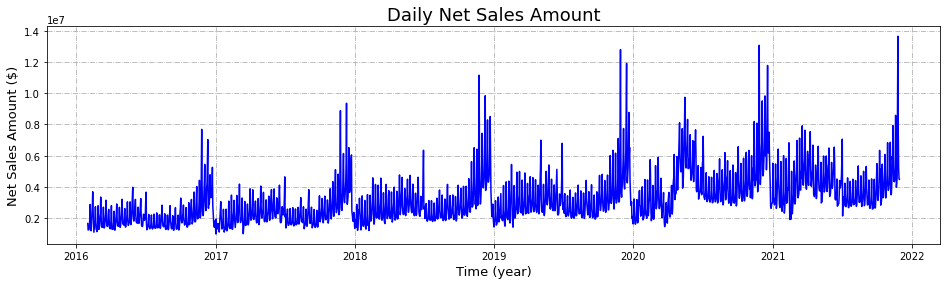

In [6]:
# frame up w/ grid
pyplot.figure(figsize=(16,4))
pyplot.grid(linestyle='-.')

# sketch in data
pyplot.plot(df.ds, df.y, 'b')

# set title & labels
pyplot.title('Daily Net Sales Amount', fontsize=18)
pyplot.ylabel('Net Sales Amount ($)', fontsize=13)
pyplot.xlabel('Time (year)', fontsize=13)

# display graph
pyplot.show()

In [7]:
# Setup and create time series model
m = Prophet(weekly_seasonality=True, yearly_seasonality=True, holidays=holidays, seasonality_mode='multiplicative')# #, holidays_prior_scale=0.5, changepoint_prior_scale=0.01, seasonality_prior_scale=5.0, # holidays_prior_scale=0.5,changepoint_prior_scale=0.01, seasonality_prior_scale=1.0
m.fit(df) #The last day of the dataset is not complete

# Create days for future prediction
future = m.make_future_dataframe(periods=180)

# Forecast
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


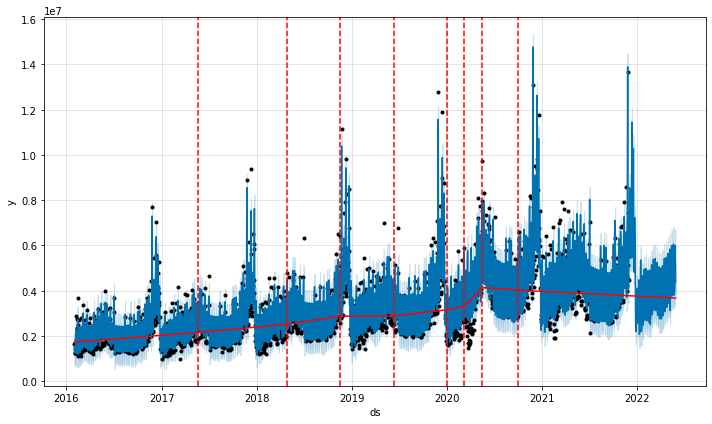

In [8]:
# https://facebook.github.io/prophet/docs/trend_changepoints.html#automatic-changepoint-detection-in-prophet
# Visualizing the locations of change points
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

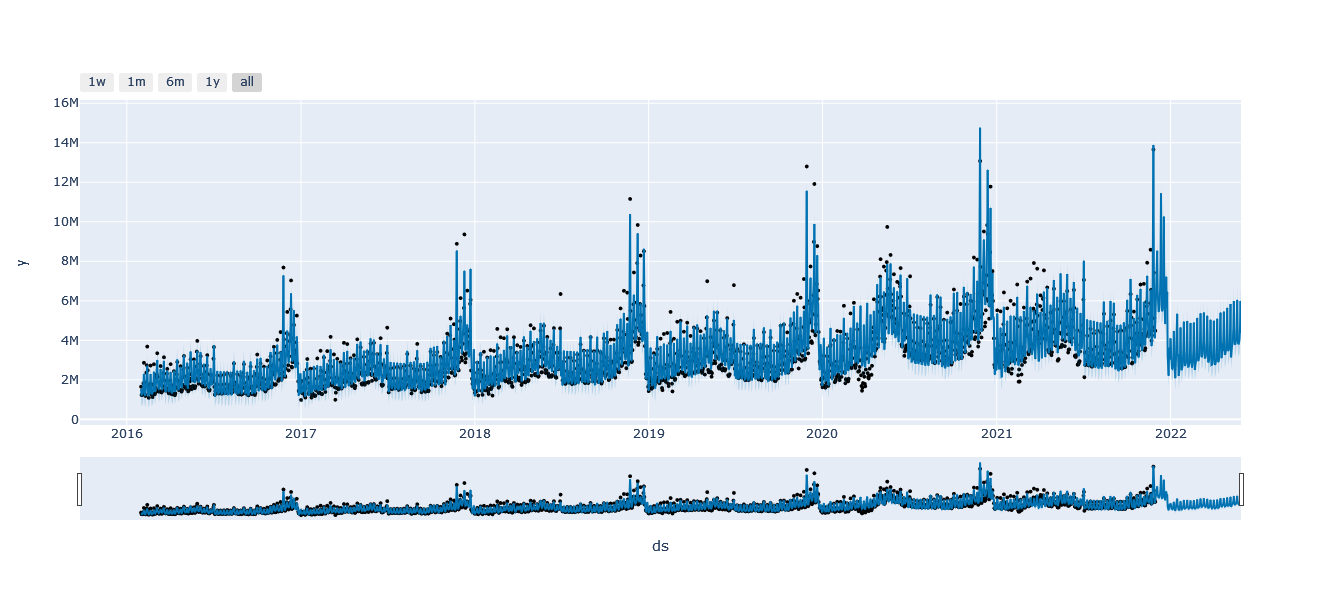

In [9]:
# Interactive figure of forecast
plot_plotly(m, forecast)

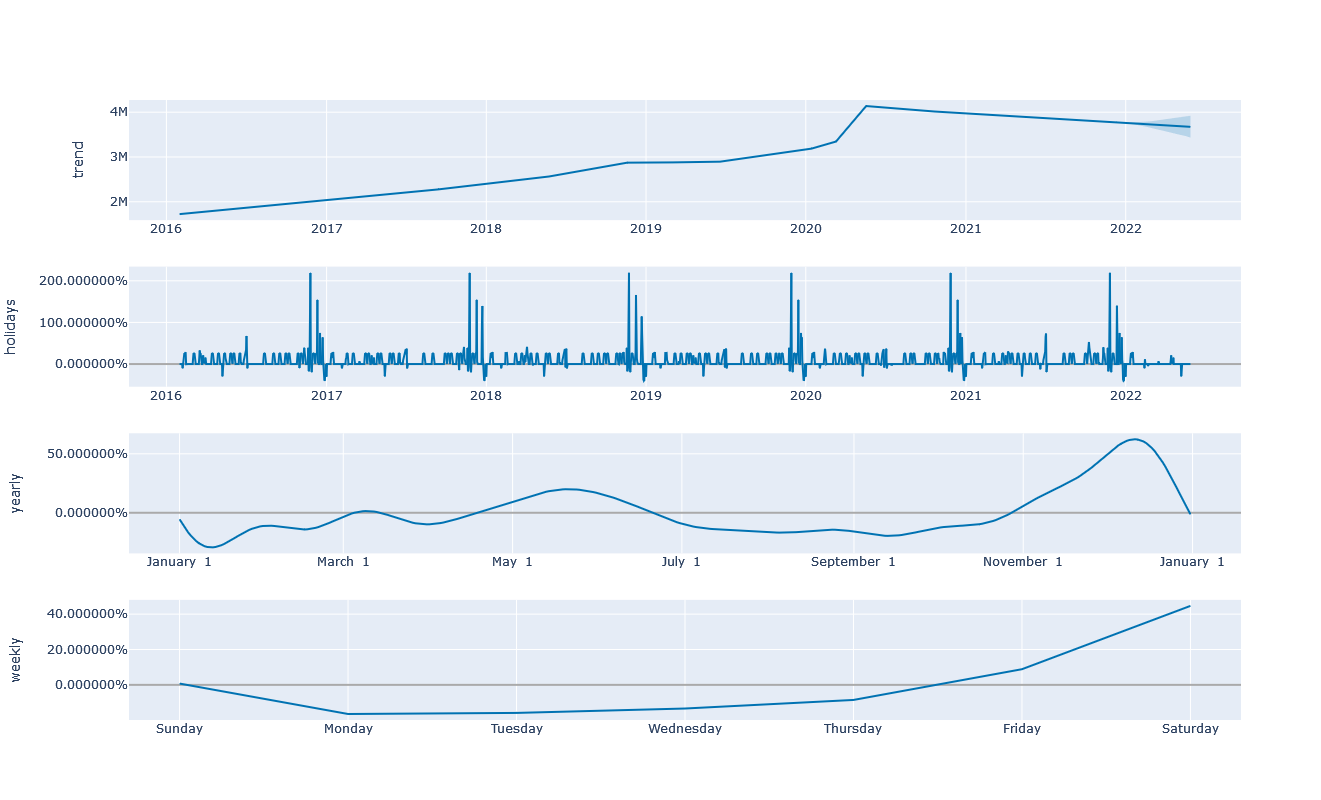

In [10]:
# Interactive figure of forecast
plot_components_plotly(m, forecast)

In [11]:
mask = ( forecast['ds'] >= '2021-12-01') & ( forecast['ds'] <= '2021-12-31')
final = forecast.loc[mask][['ds','yhat']]
final['yhat'].sum()

182201436.38180208

In [12]:
def detect_anomalies(f):
    forecasted = f[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] =  1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] == 1, 'importance'] = (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper','importance'],
        size = alt.Size('importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies).properties(width=870, height=450).configure_title(fontSize=20)



In [13]:
forecast['fact'] = df['y'].reset_index(drop = True)
pred = detect_anomalies(forecast)              
plot_anomalies(pred)

alt.LayerChart(...)

In [14]:
# Create holiday dataframe of anomalies that exist and don't have infinite importance (aka distance from model boundaries)
anomaly_df = pred.loc[(pred['anomaly']!=0) & (~np.isinf(pred['importance']))][['ds']]
anomaly_df['holiday'] = 'anomaly'
anomaly_df['lower_window'] = 0
anomaly_df['upper_window'] = 0
print("TOTAL ANOMALIES:", len(anomaly_df['ds']))
#anomaly_df

TOTAL ANOMALIES: 311


In [15]:
# Create the anomalies holidays dataframe
anomalies = pd.DataFrame(holidays.to_dict('records')+anomaly_df.to_dict('records'))
#anomalies

In [16]:
# Create list of anomalies to be removed from the dataset
remove_anomalies = pred.loc[(pred['anomaly']!=0) & (pred['importance'] >= 0.25) & (~np.isinf(pred['importance']))]['ds'].tolist()
print("TOTAL ANOMALIES TO REMOVE:", len(remove_anomalies))
#remove_anomalies

TOTAL ANOMALIES TO REMOVE: 20


In [17]:
#modified_data = df.loc[(~df['ds'].isin(remove_anomalies)) & (df['ds']<='2020-2-1') | (df['ds']>='2020-12-31')] #remove anomalies and 2020 data
modified_data = df.loc[(~df['ds'].isin(remove_anomalies)) ] #remove anomalies

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


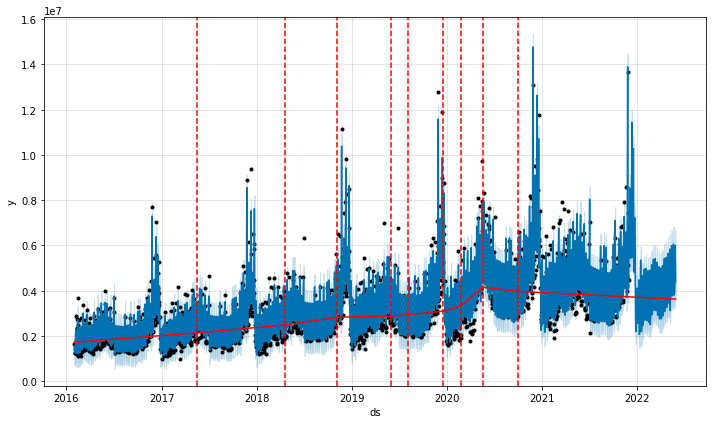

In [18]:
# Redo the forecast model with anolies removed and added to holidays as well as removing 2020 entirely
# Fit the model to the historical data
anomaly_model = Prophet(weekly_seasonality=True, yearly_seasonality=True, holidays=anomalies, seasonality_mode='multiplicative',holidays_prior_scale=0.5)# #, holidays_prior_scale=0.5, changepoint_prior_scale=0.01, seasonality_prior_scale=5.0, # holidays_prior_scale=0.5,changepoint_prior_scale=0.01, seasonality_prior_scale=1.0
anomaly_model.fit(modified_data) #df.loc[df['ds']<='2021-11-26']

# Create days for future prediction
anomaly_future = anomaly_model.make_future_dataframe(periods=180)

# Forecast
anomaly_forecast = anomaly_model.predict(anomaly_future)

# https://facebook.github.io/prophet/docs/trend_changepoints.html#automatic-changepoint-detection-in-prophet
# Visualizing the locations of change points
fig = anomaly_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), anomaly_model, anomaly_forecast)

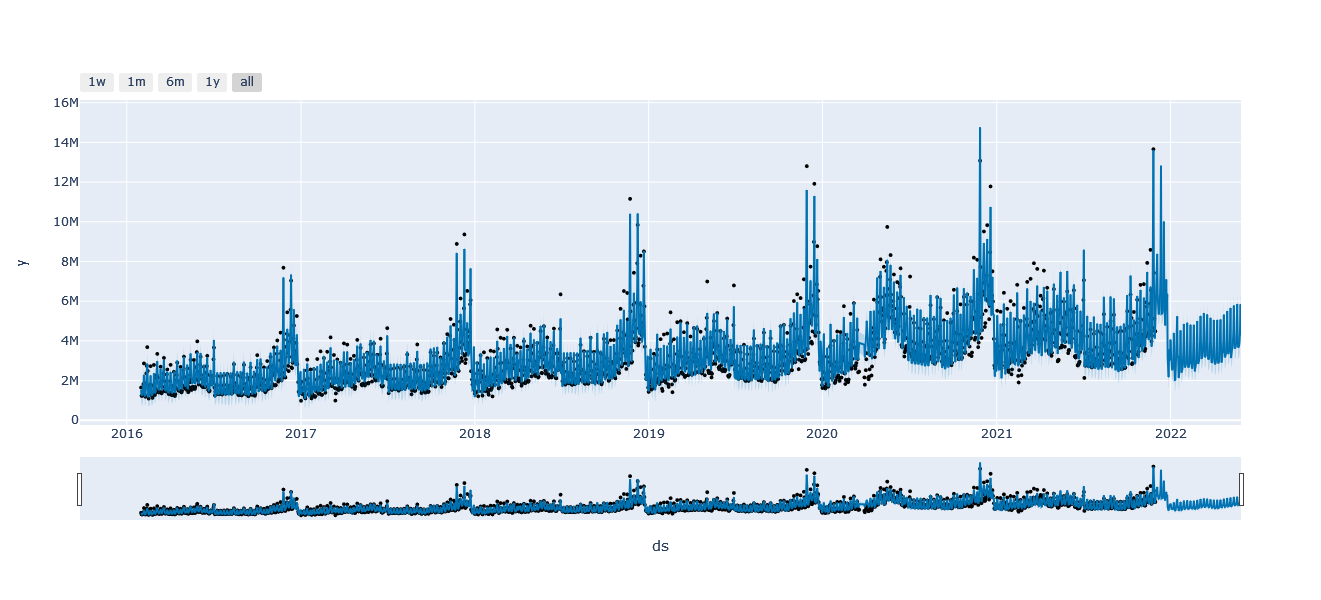

In [19]:
# Interactive figure of forecast
plot_plotly(anomaly_model, anomaly_forecast)

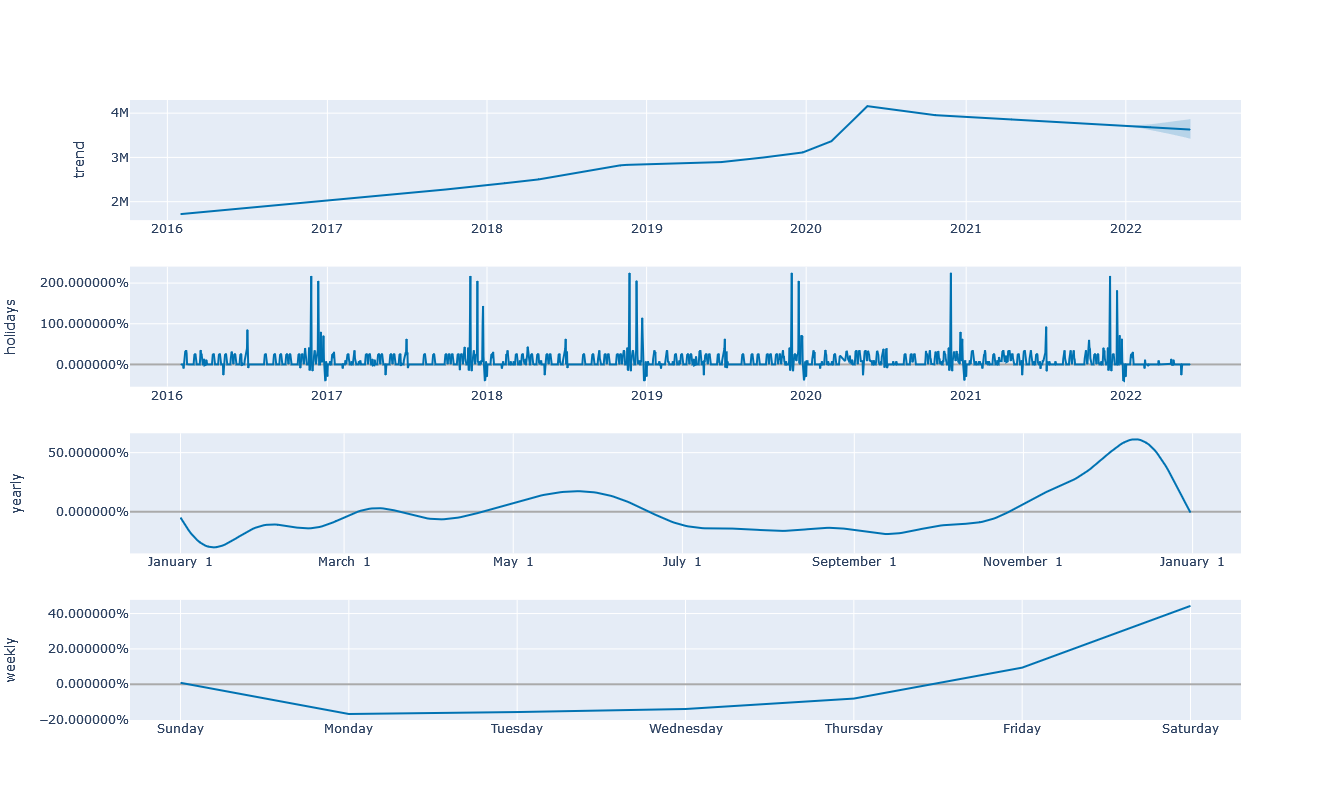

In [20]:
# Interactive figure of forecast
plot_components_plotly(anomaly_model, anomaly_forecast)

In [21]:
mask = ( anomaly_forecast['ds'] >= '2021-11-15') & ( anomaly_forecast['ds'] <= '2021-12-1')
final = anomaly_forecast.loc[mask][['ds','yhat']]
final

ds          yhat
2079 2021-11-15  4.130900e+06
2080 2021-11-16  4.031368e+06
2081 2021-11-17  4.135371e+06
2082 2021-11-18  4.397480e+06
2083 2021-11-19  5.395686e+06
2084 2021-11-20  6.746839e+06
2085 2021-11-21  6.444906e+06
2086 2021-11-22  3.695854e+06
2087 2021-11-23  3.878691e+06
2088 2021-11-24  4.379846e+06
2089 2021-11-26  1.361842e+07
2090 2021-11-27  7.344258e+06
2091 2021-11-28  4.845581e+06
2092 2021-11-29  4.103770e+06
2093 2021-11-30  4.851607e+06
2094 2021-12-01  5.508689e+06

In [22]:
mask = ( anomaly_forecast['ds'] >= '2021-12-01') & ( anomaly_forecast['ds'] <= '2021-12-31')
final = anomaly_forecast.loc[mask][['ds','yhat']]
final['yhat'].sum()

180478888.6561917